# Learning Machine Learning - Some TensorFlow experiments
E. Krupczak  - 18 Aug 2018


In [ ]:
#Testing installation
import tensorflow as tf
#Make a node
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
#Give next value of 'hello' node
print(sess.run(hello))

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
sess = tf.InteractiveSession()

Types of nodes:
- Placeholders: feed in data
- Variables: hold parameters of model
- Computational nodes: represent eg. matrix multiplication. These computational nodes can sometimes have side effects,  make additional nodes, etc

In [ ]:
#List of vectors of length 4
input_ph = tf.placeholder(tf.float32, shape=[None,4]) #If dimension in shape is none, that dimension can be arbitrarily long

In [ ]:
output = input_ph + 2*input_ph #Making a node in the graph

In [ ]:
#values for the input
input_array = np.random.randn(4,4)
input_array

In [ ]:
#Run the output node
#feed dict: specify for every placeholder what its value is
sess.run(output, feed_dict={
    input_ph:input_array,
})

Variables: takes in an initial set of value and returns a special kind of node that declares to the graph that this variable might be changed by an optimization. E.g. parameters of a model

## Linear regression
Linear regression over continuous variables. Output value of our linear regression is:
$$y = \vec{w}\cdot\vec{x}+c$$
for output variable $y$, weight vector $\vec{w}$ and variable vector $\vec{x}$ and intercept $c$.

Our goal is to minimize the squared error in the output $y$, so for a given predctor variable vector (i.e. set of predictive (independent) variables) $\vec{x_0}$ and dependent variable $y_0$ in the training set, the error which we seek to minimize is:
$$|y_0- y|^2 = |y_0 - (\vec{w}\cdot\vec{x_0}+c)|^2$$

We will minimze this error using gradient descent, which is somewhat overkill for this model for which we could use SVD. But we'll do this for pedagogical purposes.

In [ ]:
#Make some data with a linear trend
xs = np.random.randn(100,1)
ys = 1.7 + xs[:,0] * 0.6+np.random.randn(100)*0.6

In [ ]:
plt.plot(xs,ys, 'bo')
plt.show()

In [2]:
#Set the weights for each variable - in this case just one variable - and the intercept
weights = tf.Variable([0.1])
offset = tf.Variable(0.1)

In [3]:
#Build our model
#Make input placeholder
x_ph = tf.placeholder(tf.float32, shape=[None,1], name = 'x_ph') #List of length-1 vectors
#Make input placeholder
y_ph = tf.placeholder(tf.float32, shape=[None], name = 'y_ph')

#Node containing shape of predictive model
#Numpy broadcasting rules for matrix multiplication will do the right thing here: [None,1]*[1] = [None]
#Pay attention to the shapes and to tf.matmul vs tf.tensordot behavior
prediction = tf.tensordot(x_ph,weights,axes=1) + offset

#Node containing loss function to minimize
#Minimize average loss (i.e. error squared) across all points
loss = tf.reduce_mean((y_ph - prediction)**2, axis=0)

#Gradient descent with 'GradientDescentOptimizer'
learning_rate = 0.1
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
#Learning rate can be a placeholder or result of another computation elsewhere in the graph

#Create session
#interactive session will be referenced by prediction.eval
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
#Make a new session at the same time as the gradient descent, 
# so that gradient descent can't be run several times for one session

In [ ]:
prediction.shape #[None,1]*[1] = [None]

In [ ]:
#Compute prediction with initial weight, offset
sess.run(prediction, feed_dict = {x_ph: [[0],[1],[2]]})

In [ ]:
#Test set:
x = [0,1,2]
y = [0.5, 1.0, 1.5]

In [ ]:
#Compute loss - simple test model 
print(sess.run(loss,feed_dict = {
             x_ph: [[i] for i in x],
             y_ph: [0.5, 1.0, 1.5],
}))

plt.scatter(x,y)
prediction_outputs = sess.run(prediction, feed_dict={x_ph:[[i] for i in x],})
_=plt.plot(x,prediction_outputs, 'ro')

In [ ]:
#Compute loss - entire training set
print(sess.run(loss,feed_dict = {
             x_ph: xs,
             y_ph: ys,
}))

plt.scatter(xs,ys)
prediction_outputs = sess.run(prediction, feed_dict={x_ph:xs,})
_=plt.plot(xs,prediction_outputs, 'ro')

Be careful: y_ph and x_ph must be the same length in order to do the right thing, but tensorflow won't check it and will use numpy broadcasting rules for vectors of length 1.

## Gradient descent

Optimize linear regression using gradient descent - first with simplest/default optimizer ("Gradient descent optimizer")

In [ ]:
#Run the train step node, which has the side effect of performing a step.
sess.run(train_step,feed_dict = {
             x_ph: xs,
             y_ph: ys,
})

In [ ]:
weights_list = []
loss_list = []
offset_list = []
for i in range(0,100):
    sess.run(train_step,feed_dict = {
             x_ph: xs,
             y_ph: ys,
    })
    weights_list = weights_list + [sess.run(weights)]
    offset_list = offset_list + [sess.run(offset)]
    loss_step = sess.run(loss,feed_dict = {
             x_ph: xs,
             y_ph: ys,})
    loss_list = loss_list + [loss_step]

In [ ]:
plt.plot(loss_list)
plt.plot(offset_list)
plt.plot(weights_list)
plt.legend(['loss', 'offset', 'weight'])

In [ ]:
weights_list[-1]

In [ ]:
loss_list[-1]

In [ ]:
offset_list[-1]

In [ ]:
plt.scatter(xs,ys)
prediction_outputs = sess.run(prediction, feed_dict={x_ph:xs,})
_=plt.plot(xs,prediction_outputs, 'ro')

We find that this has converged to very close to the original parameters we used to make the data, with some loss irreducable due to noise. 

This was a linear model, but no reason we can't make something more complicated

## Quadratic model
We will add and modify a few things in our model to make it more complicated, starting by adding a quadratic term 

In [7]:
#A weight to use for the quadratic term
weights2 = tf.Variable([0.1])
#Quadratic Model
prediction = offset + tf.tensordot(x_ph, weights, axes=1) + tf.tensordot(x_ph**2, weights2, axes=1)

#Node containing loss function to minimize
#Minimize average loss (i.e. error squared) across all points
loss = tf.reduce_mean((y_ph - prediction)**2, axis=0)

#Gradient descent with 'GradientDescentOptimizer'
learning_rate = 0.1
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
#Learning rate can be a placeholder or result of another computation elsewhere in the graph

#New data with a quadratic trend
xs = np.random.randn(100,1)
ys = 1.7 + xs[:,0] * 0.6 - 1.3*xs[:,0]**2 +np.random.randn(100)*0.6

#New session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

5.747785


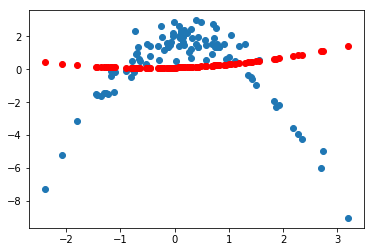

In [8]:
#Compute loss - entire training set
print(sess.run(loss,feed_dict = {
             x_ph: xs,
             y_ph: ys,
}))

#Plot data vs prediction for original variable values
plt.scatter(xs,ys)
prediction_outputs = sess.run(prediction, feed_dict={x_ph:xs,})
_=plt.plot(xs,prediction_outputs, 'ro')

In [9]:
#Train
weights_list = []
loss_list = []
offset_list = []
for i in range(0,100):
    sess.run(train_step,feed_dict = {
             x_ph: xs,
             y_ph: ys,
    })
    weights_list.append(sess.run(weights))
    offset_list.append(sess.run(offset))
    loss_step = sess.run(loss,feed_dict = {
             x_ph: xs,
             y_ph: ys,})
    loss_list.append(loss_step)

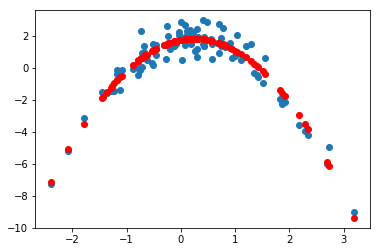

In [10]:
plt.scatter(xs,ys)
prediction_outputs = sess.run(prediction, feed_dict={x_ph:xs,})
_=plt.plot(xs,prediction_outputs, 'ro')

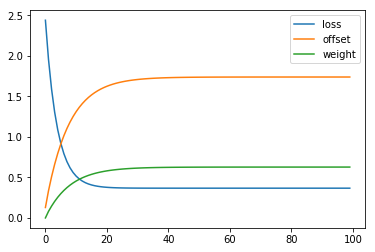

In [11]:
plt.plot(loss_list)
plt.plot(offset_list)
plt.plot(weights_list)
plt.legend(['loss', 'offset', 'weight'])